# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. Now we want to know how good the model is!

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

In [1]:
data_link = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
!wget -c $data_link -O data-week-3.csv

--2023-10-06 21:26:00--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... failed: Temporary failure in name resolution.
wget: unable to resolve host address ‘raw.githubusercontent.com’


***Metric*** - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [4]:
df = pd.read_csv("data-week-3.csv")
### Pre-Processing ###

df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)


for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors="coerce")
df["totalcharges"] = df["totalcharges"].fillna(0)

# converting churn to binary (numeric) variable
df["churn"] = (df["churn"] == "yes").astype(int) 

In [5]:
rs = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["churn"].values
y_val = df_val["churn"].values
y_test = df_test["churn"].values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]


Feature Transformation and Training of the model

In [7]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[categorical + numerical].to_dict(orient="records")

X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [8]:
val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
acc = (y_val == churn_decision).mean()
print(f"accuracy: {acc:.2f} | {acc*100:.2f}%")

accuracy: 0.80 | 80.34%


## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [9]:
N_val = len(y_val)
correct = (y_val == churn_decision).sum()
print("all: ", N_val)
print("correc: ", correct)
print(f"acc: {correct / N_val * 100:.2f}%")

all:  1409
correc:  1132
acc: 80.34%


Evaluating different decision thresholds

[0.5        0.80340667]


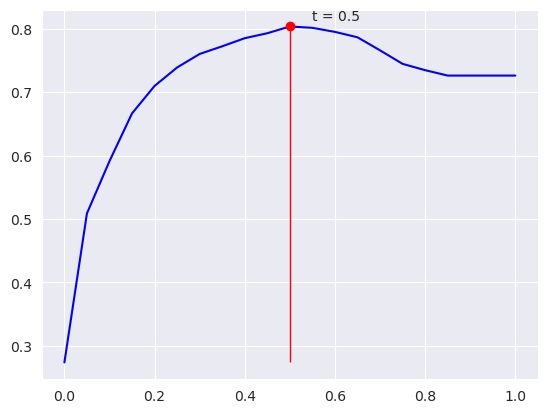

In [10]:
thresholds = np.linspace(0, 1, 21)

scores = np.zeros((len(thresholds), 2))

for i, t in enumerate(thresholds):
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores[i] = [t, score]

# Get threshold by best score
best_score = scores[:, -1].argmax()
result = scores[best_score]
print(result)

plt.plot(scores[:, 0], scores[:, 1], color='b')
plt.plot(result[0], result[1], 'ro') 
plt.text(result[0] + 0.05, result[1] + 0.01, s=f"t = {result[0]}")
plt.vlines(result[0], ymin=scores[:, -1].min(), ymax=result[1], color="red", linewidth=1)
plt.show()

The `scikit-learn` version of computing the accuracy

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

[0.5        0.80340667]


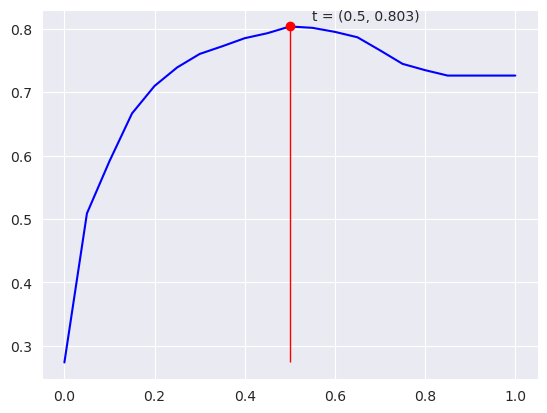

In [13]:
thresholds = np.linspace(0, 1, 21)

scores = np.zeros((len(thresholds), 2))

for i, t in enumerate(thresholds):
    score = accuracy_score(y_val, y_pred >= t)
    scores[i] = [t, score]

# Get threshold by best score
best_score = scores[:, -1].argmax()
result = scores[best_score]
print(result)

plt.plot(scores[:, 0], scores[:, 1], color='b')
plt.plot(result[0], result[1], 'ro') 
plt.text(result[0] + 0.05, result[1] + 0.01, s=f"t = {(result[0], np.round(result[1], 3))}")
plt.vlines(result[0], ymin=scores[:, -1].min(), ymax=result[1], color="red", linewidth=1)
plt.show()

**Interpretation of leftmost and rightmost thresholds**

In [14]:
from collections import Counter

In [15]:
print(Counter(y_pred >= 1.0)) # Everything is False
print(Counter(y_pred >= 0.0)) # Everything is True

Counter({False: 1409})
Counter({True: 1409})


The model, that classifies every customer of non-churning still has an accuracy of about $73\%$. This model is the dummy model.

The distrivution of labels in the target variable

In [16]:
print(Counter(y_val))

print(f"Churning: {y_val.mean():.3f}")
print(f"Non Churning: {1 - y_val.mean():.3f}")


Counter({0: 1023, 1: 386})
Churning: 0.274
Non Churning: 0.726


There are much more non-churning customers. This class-imbalance is detrimental to the effectiveness of the accuracy metric.

## 4.3 Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

![conf-tree](../imgs/confusion_matrix.png)

Implementation of the confusion matrix and its related concepts based on the visualization

In [17]:
# The true values
true_positive = (y_val == 1)
true_negative = (y_val == 0)

# The predicted value
t = 0.5
pred_positive = (y_pred >= t)
pred_negative = (y_pred < t)

Logical `AND` / `&`:

| $\land$ | `T` | `F` |
| ------- | --- | --- |
|   `T`   |  T  |  F  |
|   `F`   |  F  |  F  |

True / correct predicted values

In [18]:
tp = (pred_positive & true_positive).sum()
tn = (pred_negative & true_negative).sum()
print(f"tp: {tp} | tn: {tn}")

tp: 210 | tn: 922


False / incorrect predicted values

In [19]:
fp = (pred_positive & true_negative).sum()
fn = (pred_negative & true_positive).sum()
print(f"fp: {fp} | fn: {fn}")

fp: 101 | fn: 176


confusion-matrix:
 [[922 101]
 [176 210]]
confusion_matrix (relative)
 [[0.65 0.07]
 [0.12 0.15]]


<Axes: >

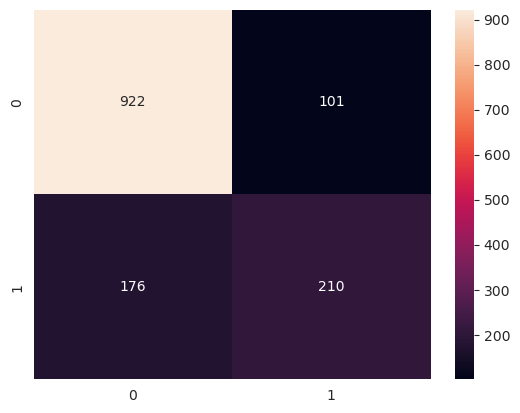

In [20]:
confusion_matrix = np.array([[tn, fp], 
                             [fn, tp]])
relative_confusion_matrix = (confusion_matrix / confusion_matrix.sum())
print("confusion-matrix:\n", confusion_matrix)
print("confusion_matrix (relative)\n", (confusion_matrix / confusion_matrix.sum()).round(2))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f")

In the confusion matrix we can see, that there are more `False Negatives` (176) than `False Positives` (101).
- `False Positve` means here: sending a promotional email to customers, that dont require them (we loose money)
- `False Negative` means here: sending no mail to a churning customer, wich means that we lose the customer (loose money also)

In [21]:
accuracy = np.diag(relative_confusion_matrix).sum()
print(f"accuracy: {accuracy:.2f}")

accuracy: 0.80


The numbers computed in `tp`, `tn`, `fp` and `fn` can also be used for other metrics which can be seen in the following section.

## 4.4 Precision and Recall

In [22]:
positive = tp + fp
negative = tn + fn
N = positive + negative

### Accuracy

$\text{accuracy} = \frac{tp + tn}{tp + fp + tn + fn}$

In [23]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
print("tp + tn = ", tp + tn)
print("tp + tn + fp + fn = ", N)
print(f"accuracy = {tp+tn}/{N} = {accuracy:.3f} | {accuracy*100:.2f}%")

tp + tn =  1132
tp + tn + fp + fn =  1409
accuracy = 1132/1409 = 0.803 | 80.34%


### Precision

$\text{precision} = \frac{tp}{tp + fp}$

In [24]:
precision = tp / (tp + fp)
print(f"precision = {tp}/{positive} = {precision:.3f} | {precision*100:.2f}%")

precision = 210/311 = 0.675 | 67.52%


Insight from `precision`: 

- The promotional mail was sent out to 311 customers, but only 210 were about to churn.
- About $33\%$ got the promotional email, but they were not supposed to.

### Recall

$\text{recall} = \frac{tp}{tp + fn}$

In [25]:
recall = tp / (tp + fn)
print(f"recall = {tp}/{tp + fn} = {recall:.3f} | {recall*100:.2f}%")

recall = 210/386 = 0.544 | 54.40%


Insight from `recall`:


- We failed to identify $\approx 46\%$ of churning customers with a recall of $\approx 54\%$

## 4.5 ROC Curves

**TPR and FPR**

In [26]:
tpr = tp / (tp + fn)
print(f"TPR = {tpr:.6f}")

fpr = fp / (fp + tn)
print(f"FPR = {fpr:.6f}")


TPR = 0.544041
FPR = 0.098729


The `TPR` is the same as the `recall`-metric

In [27]:
recall == tpr

True

Plot the ROC curve with different thresholds

In [28]:
thresholds = np.linspace(0, 1, 101)
scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    pred_positive = (y_pred >= t)
    pred_negative = (y_pred < t)

    tp = (pred_positive & actual_positive).sum()
    tn = (pred_negative & actual_negative).sum()

    fp = (pred_positive & actual_negative).sum()
    fn = (pred_negative & actual_positive).sum()

    scores.append((t, tp, fp, tn, fn))

Creating dataframe from the results

In [29]:
columns = ["threshold", "tp", "fp", "tn", "fn"]
df_scores = pd.DataFrame(scores, columns=columns)

In [30]:
df_scores["tpr"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])
df_scores["fpr"] = df_scores["fp"] / (df_scores["fp"] + df_scores["tn"])


In [31]:
df_scores.head()

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,912,111,1,0.997409,0.891496
2,0.02,384,829,194,2,0.994819,0.810362
3,0.03,383,766,257,3,0.992228,0.748778
4,0.04,381,715,308,5,0.987047,0.698925


Plotting `TPR` and `FPR`

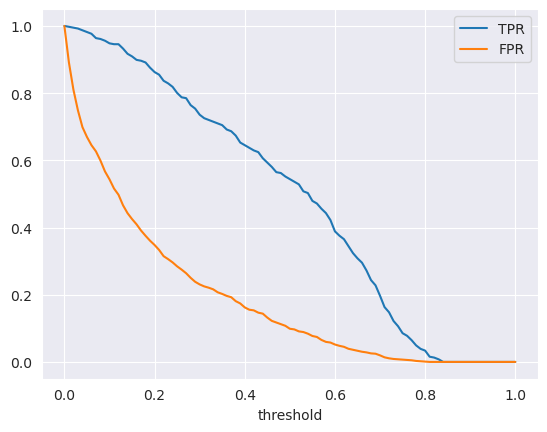

In [32]:
plt.plot(df_scores["threshold"], df_scores["tpr"], label="TPR")
plt.plot(df_scores["threshold"], df_scores["fpr"], label="FPR")
plt.xlabel("threshold")
plt.legend()
plt.show()


- The `TPR` is 1 at the threshold 0, where everything is predicted as true (churning).
- The `FPR` is also 1 at the threshold 0, because we predict everything flase (not churning), that really is true (churning).

**Random Model**

- Model that is purely random and works like a coin-toss

In [33]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [34]:
((y_rand >= 0.5) == y_val).mean() # ~= 50% (Expected)

0.5017743080198722

In [35]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        pred_positive = (y_pred >= t)
        pred_negative = (y_pred < t)
    
        tp = (pred_positive & actual_positive).sum()
        tn = (pred_negative & actual_negative).sum()
    
        fp = (pred_positive & actual_negative).sum()
        fn = (pred_negative & actual_positive).sum()
    
        scores.append((t, tp, fp, tn, fn))

    columns = ["threshold", "tp", "fp", "tn", "fn"]
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores["tpr"] = df_scores["tp"] / (df_scores["tp"] + df_scores["fn"])
    df_scores["fpr"] = df_scores["fp"] / (df_scores["fp"] + df_scores["tn"])

    return df_scores


In [36]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

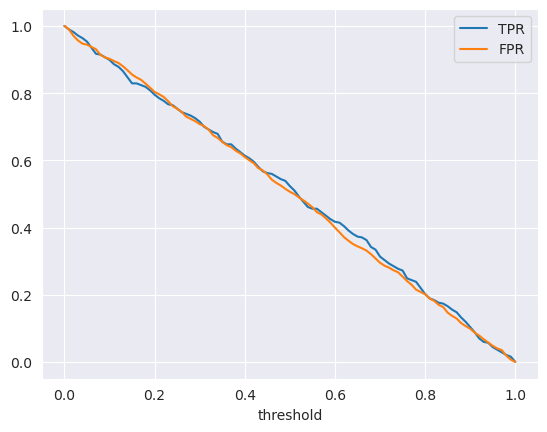

In [37]:
plt.plot(df_rand["threshold"], df_rand["tpr"], label="TPR")
plt.plot(df_rand["threshold"], df_rand["fpr"], label="FPR")
plt.xlabel("threshold")
plt.legend()
plt.show()


- A random model that basically has the functionality of a coin-toss has a nearly exact negative linear relationship with the threshold.
- If a threshold of $0.6$ is chosen, the model predicts that a customer is "non-churning" in 60% of the cases and 40% in all other cases

**Ideal Model**

- Model that does the work perfectly
- Sadly does not exist in the real world

In [38]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos


(1023, 386)

In [39]:
y_ideal = np.repeat([0, 1], repeats=[num_neg, num_pos])
y_ideal.shape

(1409,)

In [40]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [41]:
1.0 - y_val.mean()

0.7260468417317246

Choosing the values $1-\mu_y$ a threshold for classification

In [42]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [43]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

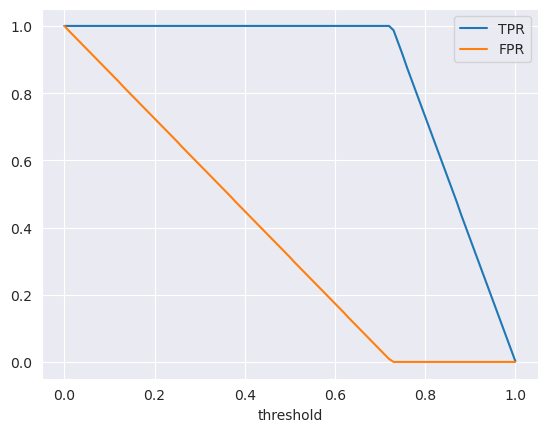

In [44]:
plt.plot(df_ideal["threshold"], df_ideal["tpr"], label="TPR")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], label="FPR")
plt.xlabel("threshold")
plt.legend()
plt.show()

- `TPR` stays at $1.0$ (100%) for a long time until a certain threshold is.
- Everything until $t^* = 0.726$ is 0 and everything after it is $1$
- If the threshold is higher than $t^*$, then the values between $t^*$ and the new threshold become false negatives thus reducing the $\text{TPR} = \frac{TP}{TP + FN}$ that has `fn` in the denominator. This describest the steep falloff after the optimal threshold.
- The drop of the `FPR` until $t^*$ is caused declining numbers of false positives the more the threshold approaches the optimal threshold $t^*$.

**Plotting all Models together (normal, random & ideal model)**

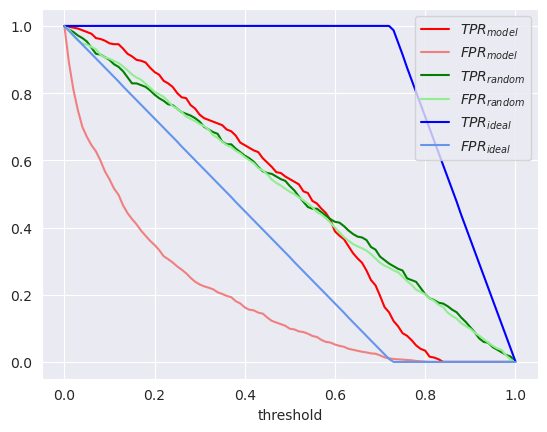

In [45]:
plt.plot(df_scores["threshold"], df_scores["tpr"], color="red", label=r"$TPR_{model}$")
plt.plot(df_scores["threshold"], df_scores["fpr"], color="lightcoral", label=r"$FPR_{model}$")

plt.plot(df_rand["threshold"], df_rand["tpr"], color="green", label=r"$TPR_{random}$")
plt.plot(df_rand["threshold"], df_rand["fpr"], color="lightgreen", label=r"$FPR_{random}$")

plt.plot(df_ideal["threshold"], df_ideal["tpr"], color="blue", label=r"$TPR_{ideal}$")
plt.plot(df_ideal["threshold"], df_ideal["fpr"], color="cornflowerblue", label=r"$FPR_{ideal}$")


plt.xlabel("threshold")
plt.legend()
plt.show()

**ROC-Curve**
- A Plot with the `TPR` and `FPR`

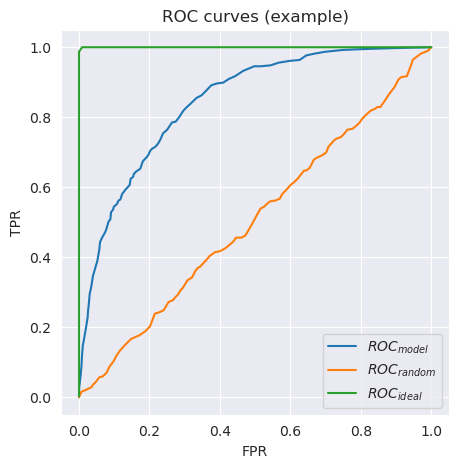

In [46]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores["fpr"], df_scores["tpr"], label=r"$ROC_{model}$")
plt.plot(df_rand["fpr"], df_rand["tpr"], label=r"$ROC_{random}$")
plt.plot(df_ideal["fpr"], df_ideal["tpr"], label=r"$ROC_{ideal}$")
plt.legend(loc="lower right")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curves (example)")
plt.show()

A more realistic example only with the trained model and the random model as reference

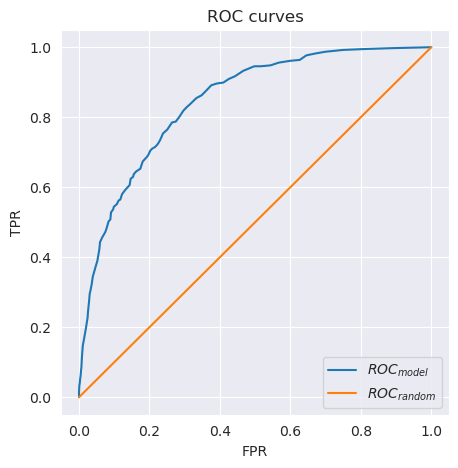

In [47]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores["fpr"], df_scores["tpr"], label=r"$ROC_{model}$")
plt.plot([0, 1], [0, 1], label=r"$ROC_{random}$")
plt.legend(loc="lower right")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curves")
plt.show()

## 4.5 Cont'd: Plotting ROC Curves with `Scikit-Learn`

In [48]:
from sklearn.metrics import roc_curve

The `scikit-learn` version of the ROC curve computation is usually more accurate, since it usually uses more thresholds.

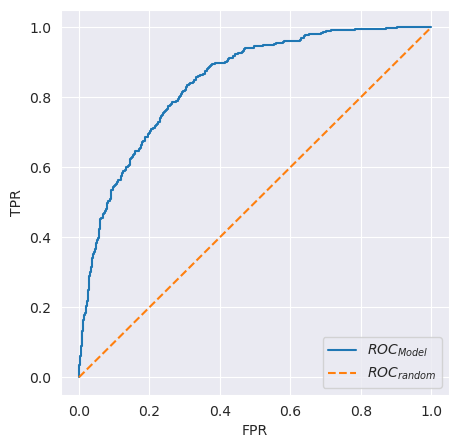

In [49]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=r"$ROC_{Model}$")
plt.plot([0, 1], [0, 1], label=r"$ROC_{random}$", linestyle="--")
plt.legend(loc="lower right")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.show()


## 4.6 ROC AUC

- Area under the ROC curve - useful metric
- Implementation of AUC

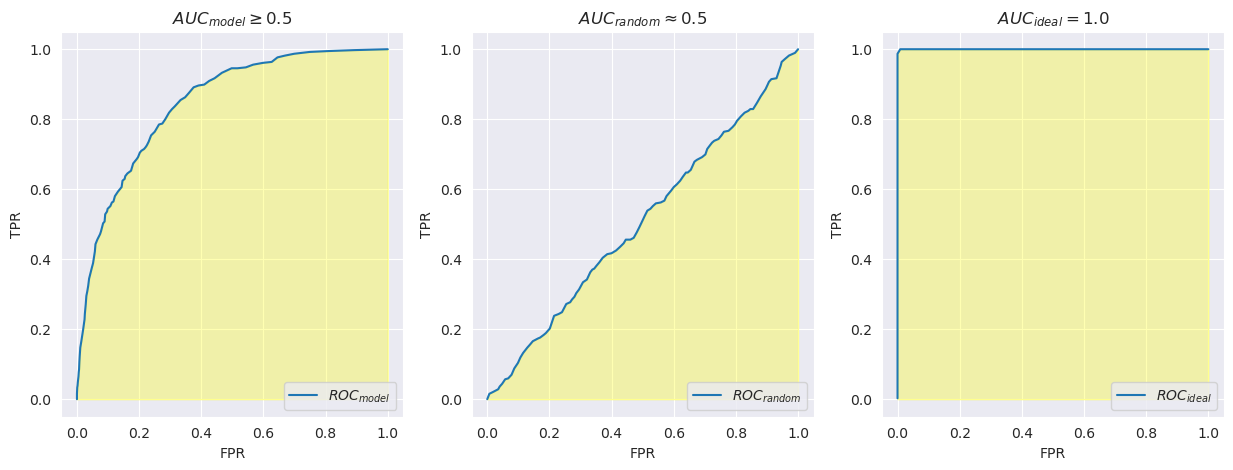

In [50]:
# Visualization of AUC

fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches((15, 5))
ax[0].plot(df_scores["fpr"], df_scores["tpr"], label=r"$ROC_{model}$")
ax[0].fill_between(df_scores["fpr"], df_scores["tpr"], color="yellow", alpha=0.3)
ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR"); ax[0].set_title(r"$AUC_{model}\geq 0.5$")
ax[0].legend(loc="lower right")

ax[1].plot(df_rand["fpr"], df_rand["tpr"], label=r"$ROC_{random}$")
ax[1].fill_between(df_rand["fpr"], df_rand["tpr"], color="yellow", alpha=0.3)
ax[1].set_xlabel("FPR"); ax[1].set_ylabel("TPR"); ax[1].set_title(r"$AUC_{random}\approx 0.5$")
ax[1].legend(loc="lower right")

ax[2].plot(df_ideal["fpr"], df_ideal["tpr"], label=r"$ROC_{ideal}$")
ax[2].fill_between(df_ideal["fpr"], df_ideal["tpr"], color="yellow", alpha=0.3)
ax[2].set_xlabel("FPR"); ax[2].set_ylabel("TPR"); ax[2].set_title(r"$AUC_{ideal} = 1.0$")
ax[2].legend(loc="lower right")
plt.savefig("../imgs/auc_models.png")
plt.show()

Implementing the AUC function

In [51]:
from sklearn.metrics import auc

In [52]:
# Using ROC obtained from scikit-learn
print(f"{auc(fpr, tpr):.8f}")

# Using ROC computed by yourself
print(f"{auc(df_scores['fpr'], df_scores['tpr']):.8f}")


0.84385051
0.84383911


The scikit-learn version is a little bit more exact, since scikit-learn evaluates the model at more thresholds than the 101 from the example show in section 4.5.

In [53]:
print(f"AUC(model): {auc(df_scores['fpr'], df_scores['tpr']):.6f}")
print(f"AUC(ideal): {auc(df_ideal['fpr'], df_ideal['tpr']):.6f}")
print(f"AUC(random): {auc(df_rand['fpr'], df_rand['tpr']):.6f}")

AUC(model): 0.843839
AUC(ideal): 0.999943
AUC(random): 0.506023


Instead of using `ROC` and `AUC` functions seperatly, there is a possiblity in scikit-learn to use both at once.

In [54]:
from sklearn.metrics import roc_auc_score

In [55]:
roc_auc_model = roc_auc_score(y_val, y_pred)
print(f"ROC+AUC: {roc_auc_model:.6f}")

ROC+AUC: 0.843851


**AUC Intuition**

In [56]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [57]:
from random import randint

Pure Python version

In [58]:
N = 100_000
scuccess = 0

for n in range(N):
    # randomly selected positive example
    pos_idx = randint(0, len(pos) - 1)

    # randomly selected negative example
    neg_idx = randint(0, len(neg) - 1)

    if pos[pos_idx] > neg[neg_idx]:
        scuccess += 1

print(f"AUC(empirical): {scuccess / N}")
print(f"AUC(model): {roc_auc_score(y_val, y_pred):.6f}")

AUC(empirical): 0.84277
AUC(model): 0.843851


Numpy Version (Vectorized)

In [59]:
N = 50_000
pos_idx = np.random.randint(0, len(pos) - 1, size=N)
neg_idx = np.random.randint(0, len(neg) - 1, size=N)

successes = (pos[pos_idx] > neg[neg_idx]).sum()
print(f"AUC(empirical): {successes / N}")
print(f"AUC(model): {roc_auc_score(y_val, y_pred):.6f}")

AUC(empirical): 0.84472
AUC(model): 0.843851


## 4.7 Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [111]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)

    X_train = dv.fit_transform(dicts)
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [112]:
dv, model = train(df_train, y_train, C=0.001)  # small C -> regularization is strong

In [113]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [114]:
y_pred = predict(df_val, dv, model)
print(y_pred.shape)

(563,)


K-Fold Cross-Validation from Scikit-Learn

In [115]:
from sklearn.model_selection import KFold
rs = 1
N = 10

Example:

In [116]:
# Initializes the K-Fold proces
kfold = KFold(n_splits=N, shuffle=True, random_state=rs)

# Apply the K-Fold split
train_idx, val_idx = next(kfold.split(df_full_train))

print("train-full: ", len(df_full_train))
print("train: ", len(train_idx), f"{len(train_idx) / len(df_full_train)*100:.0f}%")
print("val: ", len(val_idx), f"{len(val_idx) / len(df_full_train)*100:.0f}%")

# Get the dataframes with the determined split
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

train-full:  5634
train:  5070 90%
val:  564 10%


Putting all into a loop (how it should be used):

In [117]:
!pip install tqdm

In [118]:
from tqdm import tqdm

In [128]:
n_splits = 5

for C in [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]:

    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=rs)


    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train["churn"].values
        y_val = df_val["churn"].values

        dv, model = train(df_train, y_train, C)

        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print(f"C = {C:.4} | AUC: {np.mean(scores):.3f} +- {np.std(scores):.3f}")

C = 0.001 | AUC: 0.825 +- 0.009
C = 0.01 | AUC: 0.840 +- 0.009
C = 0.1 | AUC: 0.841 +- 0.008
C = 0.5 | AUC: 0.841 +- 0.007
C = 1.0 | AUC: 0.840 +- 0.008
C = 5.0 | AUC: 0.841 +- 0.008
C = 10.0 | AUC: 0.841 +- 0.008


Train the final model on the full dataset and test it on the test-dataset

In [130]:
dv, model = train(df_full_train, df_full_train["churn"].values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
print(f"AUC(full): {auc:.6f}")

AUC(full): 0.857239


You can see, that the final AUC is not that different from the results obtained during the K-fold cross-validation. The AUC is even a little bit higher.

## 4.8 Summary

| **Concept**                        | **Meaning**
| ---------------------------------- | -------------------------------------------------------------------------------- |
| **`Metric`**                       | A single number that describes the performance of a model                        |
| **`Accuracy`**                     | Fraction of correct answers; sometimes misleading                                |
| **`Precision`** and **`Recall`**   | Less missleading when we have a class imbalance                                  |
| **`ROC Curve`**                    | A way to evaluate the performance at all thresholds; okay to use with imbalance  |
| **`K-Fold Cross-Validation`**      | More reliable estimate for performance (mean + std)                              |


## 4.9 Explore more

- Check the precision and recall of the dummy classifier that always predict "`FALSE`"
- **`F1 Score`**: $F_1 = 2\cdot\frac{P \cdot R}{P + R},\qquad P:=\text{Precision}, R:=\text{Recall}$
- Evaluate `Precision` and `Recall` at different thresholds, plot `P` vs `R` - this way you will get the `Precision` / `Recall` curve (similar to the ROC curve)
    - Area Under Precision-Recall (AUPR) is also a useful metric 


**Other Projects:**
- Calculate the metrics for datasets from the previous week